# Description

Initial EDA for potential propensity score matching leakage.

In [1]:
# source: https://stackoverflow.com/a/28073228
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import ipywidgets as widgets

from ipywidgets import interact, interact_manual

%matplotlib inline
%load_ext autoreload
%autoreload 2


Bad key text.latex.preview in file /home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the de

In [3]:
# user imports

from utils import compute_study_pairs

# Load data

In [4]:
# sheet_name=None loads all sheets as a dict
psm_leak_dict = pd.read_excel("data/psm_leakage.xlsx", sheet_name=None)

In [5]:
meta_studies = list(psm_leak_dict.keys())

psm_leak = pd.DataFrame()
for study, df in psm_leak_dict.items():
    df['meta_study'] = study
    psm_leak = psm_leak.append(df)
    
psm_leak = psm_leak.reset_index()

In [6]:
psm_leak.tail(10)

,index,study_type,year,clinical_setting,estimate,lower_ci,upper_ci,meta_study,month,note,area
150,22,PS,2016.0,Clopidogrel treatment duration 3 month v >3 mo...,0.20,0.00,1.300,hemkens2016,NaT,NaN,NaN
151,23,RCT,2017.0,Clopidogrel treatment duration 3 month v >3 mo...,0.91,0.61,1.350,hemkens2016,NaT,NaN,NaN
152,24,PS,2016.0,Very early angiography (within 6h) v early con...,0.89,0.69,1.170,hemkens2016,NaT,NaN,NaN
153,25,RCT,2017.0,Very early angiography (within 6h) v early con...,0.85,0.40,1.840,hemkens2016,NaT,NaN,NaN
154,26,PS,2016.0,Beta blocker continuation v beta blocker withd...,0.42,0.21,0.857,hemkens2016,NaT,NaN,NaN
155,27,RCT,2017.0,Beta blocker continuation v beta blocker withd...,0.99,0.34,2.880,hemkens2016,NaT,NaN,NaN
156,28,PS,2016.0,Surgical removal of the primary tumor v no sur...,0.64,0.59,0.680,hemkens2016,NaT,NaN,NaN
157,29,RCT,2017.0,Surgical removal of the primary tumor v no sur...,0.92,0.56,1.530,hemkens2016,NaT,NaN,NaN
158,30,PS,2016.0,"CABG v drug eluting stent, Unprotected, left m...",0.74,0.16,3.420,hemkens2016,NaT,NaN,NaN
159,31,RCT,2017.0,"CABG v drug eluting stent, Unprotected, left m...",1.23,0.70,2.170,hemkens2016,NaT,NaN,NaN


In [7]:
# create a unique study id via index
psm_leak = psm_leak.reset_index()
psm_leak = psm_leak.rename({"index": "study_id"}, axis="columns")
psm_leak['study_id'] = psm_leak['study_id'].astype(str)
psm_leak.head()
psm_leak['ci_diff'] = psm_leak['upper_ci'] - psm_leak['lower_ci']

In [8]:
psm_leak['study_type'].value_counts()

RCT    104
PS      56
Name: study_type, dtype: int64

In [9]:
psm_leak['study_type'].value_counts()

RCT    104
PS      56
Name: study_type, dtype: int64

# Clip studies with large CIs

During a live coding session, Konrad and I examined the confidence intervals
and decided to remove studies with large intervals -- the choice of 3 as the cutoff
was arbitrary based on visual inspection and more formal analysis will need a more formal method for outlier
removal (e.g. 2-3 SDs).

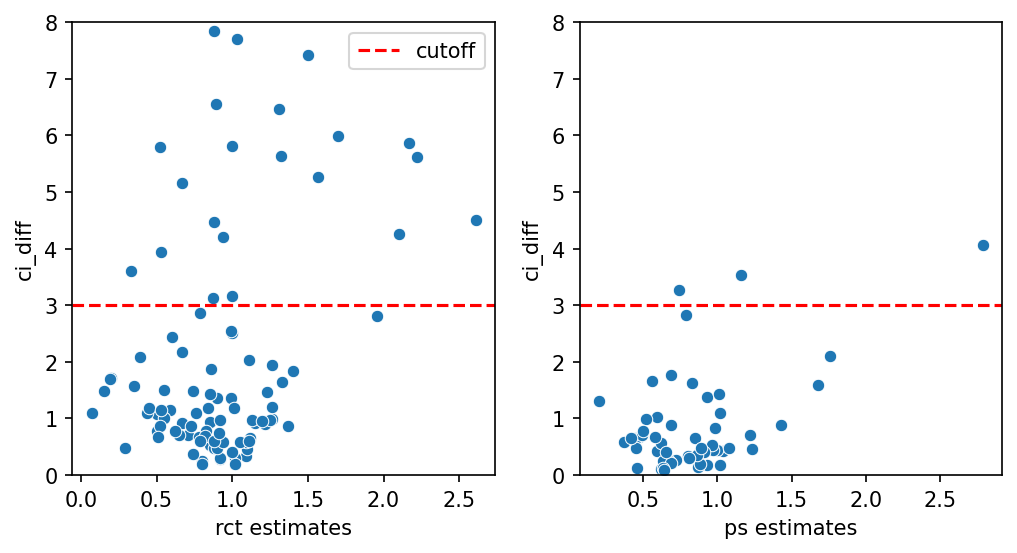

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150, figsize=(8,4))
rct = psm_leak[psm_leak['study_type'] == 'RCT']
ps = psm_leak[psm_leak['study_type'] == 'PS']

sns.scatterplot(data=rct, x='estimate', y='ci_diff', ax=ax1)
ax1.set_ylim(0, 8)
ax1.set_xlabel("rct estimates")
ax1.axhline(y=3, ls='--', color='red', label='cutoff')
ax1.legend()

sns.scatterplot(data=ps, x='estimate', y='ci_diff', ax=ax2)
ax2.set_ylim(0, 8)
ax2.axhline(y=3, ls='--', color='red', label='cutoff')
ax2.set_xlabel("ps estimates");


In [11]:
#sel_psm_leak = psm_leak[psm_leak['ci_diff'] < 3]
sel_psm_leak = psm_leak.copy()

# Compute pairwise differences

For each PS study within a clinical setting, we pair it with an RCT and compute
the year difference between each pair.

**TODO**: since this is a one-to-many mapping *per PS study*, there will be 
repeated measurements of both PS and RCT studies. More formal analysis will need
to account for this group structure.

In [12]:
pair_df = compute_study_pairs(sel_psm_leak)

# Relationship between RCT and PS estimates: regression

We'll analyze the effect estimates in log space.

In [13]:
#pair_df['rct_est'] = np.log(pair_df['rct_est'])
#pair_df['ps_est'] = np.log(pair_df['ps_est'])

For the initial analysis, we discard PS-RCT pairs that were published in the same year.

**TODO**: further data collection could take a look at the specific studies cited
and their specific month/day publication date for more granularity.

In [14]:
no_zero_pairs = pair_df[pair_df['year_diff'] != 0].copy()

In [15]:
no_zero_pairs = no_zero_pairs[~no_zero_pairs[['rct_est', 'ps_est']].isna().any(axis=1)]

In [16]:
# indicator function for the PS study coming *after* the RCT
no_zero_pairs['ps_after'] = (no_zero_pairs['year_diff'] > 0).astype(int)

In [17]:
# helper function for regression results
def get_reg_results(data, name, x, y='rct_est'):
    sel_cols = ['names', 'coef', 'se', 'pval', 'CI[2.5%]', 'CI[97.5%]']
    # we want the second entry, for the x coefficient results
    reg_results = pg.linear_regression(data[x], data[y], add_intercept=True, remove_na=True).loc[1, sel_cols]
    reg_results = reg_results.to_frame().transpose()
    reg_results.index = [name]
    return reg_results

#get_reg_results(no_zero_pairs[no_zero_pairs['ps_after'] == 0], 'test', x='ps_est')

In [18]:
no_zero_pairs['rct_ci_diff'].describe()

count    124.000000
mean       2.141613
std        3.602068
min        0.200000
25%        0.590000
50%        1.000000
75%        1.895000
max       31.320000
Name: rct_ci_diff, dtype: float64

In [27]:
group_col = 'study_id'

@interact_manual(
    group_col=['study_id', 'clinical_setting'],
    ci_diff=widgets.FloatSlider(
        value=3,
        min=1,
        max=5.0,
        step=0.1,
    )
#     meta_studies=widgets.SelectMultiple(
#         options=[None] + meta_studies,
#         value=[None],
#     )
)
def show_reg(group_col, ci_diff, log_transform=True):
    meta_studies = [None]
    
    fig, (ax1,ax2) = plt.subplots(1, 2, dpi=125, figsize=(10,4))
    
    if None in list(meta_studies):
        sel_pairs = no_zero_pairs.copy()
    else:
        sel_pairs = no_zero_pairs[no_zero_pairs['meta_study'].isin(list(meta_studies))].copy()
        
    sel_pairs = sel_pairs[(sel_pairs['rct_ci_diff'] < ci_diff) & (sel_pairs['ps_ci_diff'] < ci_diff)]
    
    if log_transform:
        sel_pairs['rct_est'] = np.log(sel_pairs['rct_est'])
        sel_pairs['ps_est'] = np.log(sel_pairs['ps_est'])

    sns.scatterplot(data=sel_pairs, x='ps_est', y='rct_est', hue='ps_after', ax=ax1)
    sns.regplot(data=sel_pairs[sel_pairs['ps_after'] == 0], x='ps_est', y='rct_est', color='blue', ax=ax1)
    sns.regplot(data=sel_pairs[sel_pairs['ps_after'] == 1], x='ps_est', y='rct_est', color='orange', ax=ax1)
    ax1.set_title("outlier clipped, individual pairs")
    ax1.set_xlabel("PS study effect estimate")
    ax1.set_ylabel("RCT study effect estimate")
    #ax1.set_ylim(-1.25, 0.75)

    #grouped = sel_pairs.sort_values(by=[group_col, 'rct_ci_diff'], ascending=True).groupby(['ps_after', group_col], as_index=False)[['ps_est', 'rct_est']].head()
    grouped = sel_pairs.groupby(['ps_after', group_col], as_index=False)[['ps_est', 'rct_est']].mean()
    print(f"{sel_pairs.shape[0]} individual pairs")
    print(f"{grouped.shape[0]} grouped pairs")
    
    
    sns.scatterplot(data=grouped, x='ps_est', y='rct_est', hue='ps_after', ax=ax2)
    sns.regplot(data=grouped[grouped['ps_after'] == 0], x='ps_est', y='rct_est', color='blue', ax=ax2)
    sns.regplot(data=grouped[grouped['ps_after'] == 1], x='ps_est', y='rct_est', color='orange', ax=ax2)
    ax2.set_title(f"outlier clipped, grouped by {group_col}")
    ax2.set_xlabel("PS study effect estimate")
    ax2.set_ylabel("RCT study effect estimate")
    #ax2.set_ylim(-1.25, 0.75)
    
    ax1.set_box_aspect(1)
    ax2.set_box_aspect(1)

    # show regression results
    name_dict = {
        'individual pairs, before': sel_pairs[sel_pairs['ps_after'] == 0],
        'individual pairs, after': sel_pairs[sel_pairs['ps_after'] == 1],
        'grouped pairs, before': grouped[grouped['ps_after'] == 0],
        'grouped pairs, after': grouped[grouped['ps_after'] == 1],
    }

    reg_df = pd.DataFrame()
    for name, data in name_dict.items():
        df = get_reg_results(data, name, x='ps_est', y='rct_est')
        reg_df = reg_df.append(df)

    display(reg_df)

interactive(children=(Dropdown(description='group_col', options=('study_id', 'clinical_setting'), value='study…

After grouping (averaging within pairs) either by individual PS study or by clinical setting,
we see a significant positive relationship between the RCT effect estimate and the PS effect
estimate if the PS study came after the RCT, while no significant relationship between
the effects if the PS study came before the RCT.

# RCT-RCT agreement

We hypothesize that due to the additional validity controls present in RCTs, the pre-post publication effect should not exist.

In [20]:
pair_rct_df = pd.DataFrame()
for clinic_set, group in sel_psm_leak.groupby("clinical_setting"):
    rct_df = group[group['study_type'] == 'RCT']
    for rct1_idx, rct1 in rct_df.iterrows():
        ps_dict = {
            "study_id": [],
            "rct1_year": [],
            "rct2_year": [],
            "year_diff": [],
            "rct1_est": [],
            "rct2_est": [],
            "clinical_setting": [],
        }
        for rct2_idx, rct2 in rct_df.iterrows():
            if rct1_idx != rct2_idx:
                ps_dict['study_id'].append(rct1['study_id'])
                ps_dict['rct1_year'].append(rct1['year'])
                ps_dict['rct2_year'].append(rct2['year'])
                ps_dict['year_diff'].append(rct1['year'] - rct2['year'])
                ps_dict['rct1_est'].append(rct1['estimate'])
                ps_dict['rct2_est'].append(rct2['estimate'])
                ps_dict['clinical_setting'].append(rct1['clinical_setting'])

        df = pd.DataFrame.from_dict(ps_dict)
        pair_rct_df = pair_rct_df.append(df)

In [21]:
pair_rct_df

,study_id,rct1_year,rct2_year,year_diff,rct1_est,rct2_est,clinical_setting
0,26,1995.0,1997.0,-2.0,NaN,NaN,ACEi (AMI)
1,26,1995.0,1994.0,1.0,NaN,NaN,ACEi (AMI)
0,27,1997.0,1995.0,2.0,NaN,NaN,ACEi (AMI)
1,27,1997.0,1994.0,3.0,NaN,NaN,ACEi (AMI)
0,28,1994.0,1995.0,-1.0,NaN,NaN,ACEi (AMI)
...,...,...,...,...,...,...,...
0,84,2006.0,2002.0,4.0,1.05,1.01,right heart catheterization vs not
1,84,2006.0,2003.0,3.0,1.05,0.94,right heart catheterization vs not
2,84,2006.0,2005.0,1.0,1.05,1.09,right heart catheterization vs not
0,66,2004.0,2006.0,-2.0,2.17,0.39,tracheostomy vs not (ICU)


In [22]:
pair_rct_df['rct1_est'] = np.log(pair_rct_df['rct1_est'])
pair_rct_df['rct2_est'] = np.log(pair_rct_df['rct2_est'])

In [23]:
no_zero_rct_pairs = pair_rct_df[pair_rct_df['year_diff'] != 0].copy()

In [24]:
# indicator function for the PS study coming *after* the RCT
no_zero_rct_pairs['rct_after'] = (no_zero_rct_pairs['year_diff'] > 0).astype(int)

332 individual pairs
36 grouped pairs


,names,coef,se,pval,CI[2.5%],CI[97.5%]
"individual pairs, before",rct1_est,-0.000005,0.089123,0.999959,-0.176014,0.176005
"individual pairs, after",rct1_est,-0.000004,0.070128,0.999959,-0.138499,0.138492
"grouped pairs, before",rct1_est,0.110876,0.224736,0.629406,-0.371135,0.592888
"grouped pairs, after",rct1_est,0.154127,0.312401,0.629406,-0.515908,0.824162


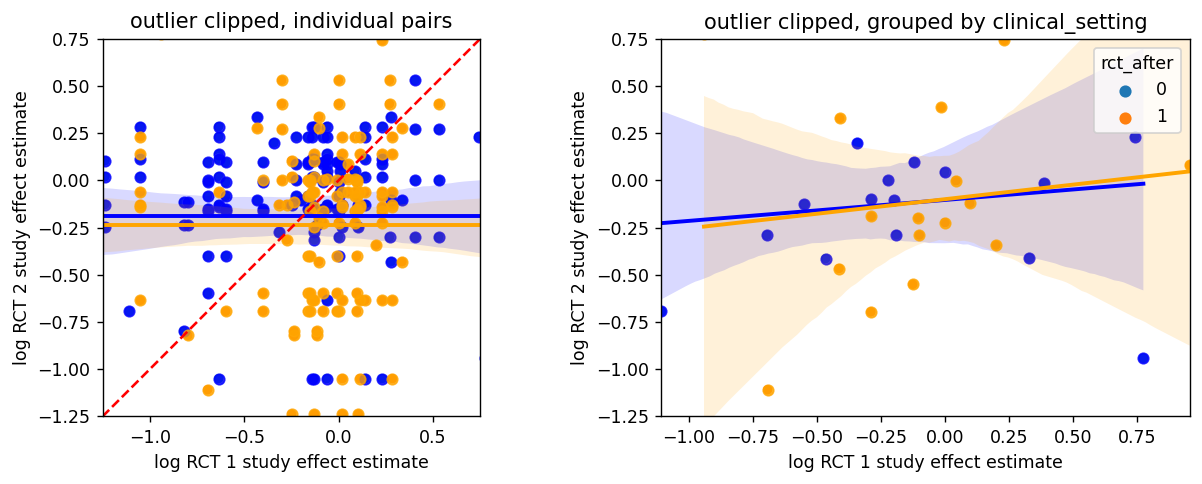

In [25]:
fig, (ax1,ax2) = plt.subplots(1, 2, dpi=125, figsize=(12,4))

sns.scatterplot(data=no_zero_rct_pairs, x='rct1_est', y='rct2_est', hue='rct_after', ax=ax1, legend=False)
sns.regplot(data=no_zero_rct_pairs[no_zero_rct_pairs['rct_after'] == 0], x='rct1_est', y='rct2_est', color='blue', ax=ax1)
sns.regplot(data=no_zero_rct_pairs[no_zero_rct_pairs['rct_after'] == 1], x='rct1_est', y='rct2_est', color='orange', ax=ax1)
ax1.set_title("outlier clipped, individual pairs")
ax1.set_xlabel("log RCT 1 study effect estimate")
ax1.set_ylabel("log RCT 2 study effect estimate")
ax1.plot(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1), ls='--', color='red')
ax1.set_ylim(-1.25, 0.75)
ax1.set_xlim(-1.25, 0.75)


group_col = "clinical_setting"
#grouped = no_zero_rct_pairs.sort_values(by=[group_col, 'rct_ci_diff'], ascending=True).groupby(['ps_after', group_col], as_index=False)[['ps_est', 'rct_est']].head()
grouped = no_zero_rct_pairs.groupby(['rct_after', group_col], as_index=False)[['rct1_est', 'rct2_est']].mean()
print(f"{no_zero_rct_pairs.shape[0]} individual pairs")
print(f"{grouped.shape[0]} grouped pairs")
x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()
ax1.set_aspect((x1-x0)/(y1-y0))


sns.scatterplot(data=grouped, x='rct1_est', y='rct2_est', hue='rct_after', ax=ax2)
sns.regplot(data=grouped[grouped['rct_after'] == 0], x='rct1_est', y='rct2_est', color='blue', ax=ax2)
sns.regplot(data=grouped[grouped['rct_after'] == 1], x='rct1_est', y='rct2_est', color='orange', ax=ax2)
ax2.set_title(f"outlier clipped, grouped by {group_col}")
ax2.set_xlabel("log RCT 1 study effect estimate")
ax2.set_ylabel("log RCT 2 study effect estimate")
ax2.set_ylim(-1.25, 0.75)

# # show regression results
name_dict = {
    'individual pairs, before': no_zero_rct_pairs[no_zero_rct_pairs['rct_after'] == 0],
    'individual pairs, after': no_zero_rct_pairs[no_zero_rct_pairs['rct_after'] == 1],
    'grouped pairs, before': grouped[grouped['rct_after'] == 0],
    'grouped pairs, after': grouped[grouped['rct_after'] == 1],
}

reg_df = pd.DataFrame()
for name, data in name_dict.items():
    df = get_reg_results(data, name, x='rct1_est', y='rct2_est')
    reg_df = reg_df.append(df)

display(reg_df)